In [1]:
%matplotlib inline


Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [20]:
import os
os.chdir('..')
os.getcwd()
from util.cifar_data_loader import get_train_val_set

In [21]:
parent_dir = os.path.abspath('..')
data_dir = parent_dir + '/data/'
train_data, val_data, train_sampler, val_sampler = get_train_val_set(data_dir=data_dir, augment=True)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
image_datasets = {'train': train_data, 'val': val_data}
image_samplers = {'train': train_sampler, 'val': val_sampler}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             sampler=image_samplers[x], num_workers=2, pin_memory=False)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



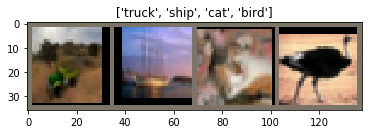

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/24
----------
train Loss: 0.7053 Acc: 0.6230
val Loss: 0.2214 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.3399 Acc: 0.8156
val Loss: 0.2148 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5299 Acc: 0.7869
val Loss: 0.1898 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5668 Acc: 0.7500
val Loss: 0.1675 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4072 Acc: 0.8279
val Loss: 0.2490 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4953 Acc: 0.7910
val Loss: 0.2045 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4391 Acc: 0.8156
val Loss: 0.2586 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2935 Acc: 0.8730
val Loss: 0.1821 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3394 Acc: 0.8525
val Loss: 0.1751 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3197 Acc: 0.8648
val Loss: 0.1766 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2754 Acc: 0.8770
val Loss: 0.1810 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2934 Acc: 0.8689
val Loss: 0.1954 Acc: 0.9281

Ep

Process Process-104:
Process Process-103:
Process Process-102:
Process Process-101:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/signapoop/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._targ

KeyboardInterrupt: 

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [9]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [24]:
image_datasets['train']

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /Users/signapoop/Desktop/data/
    Transforms (if any): Compose(
                             RandomCrop(size=(32, 32), padding=4)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [25]:
image_datasets['val']

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /Users/signapoop/Desktop/data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [15]:
class MyModel(nn.Module):
    def __init__(self, pretrained_model):
        super(MyModel, self).__init__()
        image_modules = list(pretrained_model.children())[:-1] #all layer expect last layer
        self.modelA = nn.Sequential(*image_modules)
        
    def forward(self, image):
        a = self.modelA(image)
        return a

In [28]:
model = MyModel(model_conv)

In [29]:
inputs.shape

torch.Size([4, 3, 32, 32])

In [30]:
conv_features = model(inputs)

RuntimeError: Given input size: (512x1x1). Calculated output size: (512x-5x-5). Output size is too small at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/aten/src/THNN/generic/SpatialAveragePooling.c:64

In [19]:
conv_features.shape

torch.Size([4, 512, 1, 1])